## Introduction ##

This Jupyter notebook is designed to simulate the dynamics of the activated random walk on the comb, highlighting the densities on the teeth and spine. Beginning with no particles, at each step we add an active particle at the center of the spine and then stabalize the configuration. We plot the resulting densities of particles left on the teeth and spine. We choose to represent the comb as an array, with each site corresponding to an entry of the array. Entries of -1 to represent sleeping particles at the corresponding site, and other natural numbers record the number of particles at a given site.

In [1]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#Helper method for choosing 1 of 3 options. This is called a lot so we want it to be fast. 
def rand3():
    #Find a random integer from 0,1,2. Supposedly fast?
    while True:
        r = random.getrandbits(2)
        if r < 3:
            return r

## The Comb ##

In [3]:
#Function for adding particle to the comb. Returns true only if the particle fell into a sink 
def add_particle_to_comb(comb, index_row, index_col):
    length = comb.shape[1]
    #If the index we want to move to is outside the length of the comb, we moved into a sink, so do nothing
    if index_col >= length or index_col< 0:
        #If the particle fell off, we want to find a new active particle
        return True
    #If the site we moved into has a sleeping particle, wake it up so we have 2 sleeping particles in it. 
    elif comb[index_row, index_col] == -1:
        comb[index_row, index_col] = 2
        #We can keep tracking this active particle.
        return False
    #Otherwise we have one more sleeping particle. 
    else:
        comb[index_row, index_col] += 1
        #We can keep tracking this active particle.
        return False

In [4]:
def sample_stationary_distribution_comb(comb, sleep_rate):
    #Start out searching for an active particle
    searching_for_index = True
    while(True):
        #This is expensive, so don't want to run it unless we have to
        if searching_for_index:
            #Find the index of the first site with at least one active particle. If no such index exists we are stable, and so exit. 
            positive_indices = np.flatnonzero(comb > 0)
            if positive_indices.size > 0:
                active_index = np.unravel_index(positive_indices[0], comb.shape)
                #Once we find an active particle, want to keep tracking it until it falls off or falls asleep
                searching_for_index = False
            else:
                return comb
        #If only one particle is in the active site, it can fall asleep 
        if comb[active_index] == 1:
            r = random.random()
            #Entry of -1 means sleeping particle
            if r < sleep_rate/(1+sleep_rate):
                comb[active_index] = -1
                #If a particle falls alseep, we want to find a new active particle to track
                searching_for_index = True
            else:
                #If our only active particle moved, we set the entry in the site to 0
                comb[active_index] = 0
                #If we are in the tooth, the only place to go is down
                if active_index[0] == 0:
                    active_index = (active_index[0] + 1, active_index[1])
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                else:
                    #Otherwise pick a random direction to move in
                    direction = rand3()
                    #Move up
                    if direction == 0:
                        active_index = (active_index[0] - 1, active_index[1])
                        searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                    #Move right
                    elif direction == 1:
                        active_index = (active_index[0], active_index[1] + 1)
                        searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                    #Move left
                    elif direction == 2:
                        active_index = (active_index[0], active_index[1] - 1)
                        searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
        #If multiple active particles, one must move
        else:  
            #Particle moved so reduce the number by 1
            comb[active_index] -= 1
            #If in the tooth must move down. 
            if active_index[0] == 0:
                    active_index = (active_index[0] + 1, active_index[1])
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
            else:
                #Pick a random direction to move
                direction = rand3()
                if direction == 0:
                    active_index = (active_index[0] - 1, active_index[1])
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                elif direction == 1:
                    active_index = (active_index[0], active_index[1] + 1)
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                elif direction == 2:
                    active_index = (active_index[0], active_index[1] - 1)
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])

In [5]:
def run_simulation_comb(comb_length, sleep_rate, num_trials):
    #Record these densities seperately
    tooth_density = []
    spine_density = []
    comb = np.zeros((2, comb_length))
    for _ in tqdm(range(num_trials), desc=f"Running trials (L={comb_length}, r={sleep_rate})", leave=False):
        sample_stationary_distribution_comb(comb, sleep_rate)
        tooth_density.append(np.sum(-comb[0])/comb_length)
        spine_density.append(np.sum(-comb[1])/comb_length)
        #Uniform driving. 
        particle_col = np.random.randint(comb_length)
        particle_row = random.getrandbits(1)
        add_particle_to_comb(comb, particle_row, particle_col)
    return [tooth_density, spine_density]

## Running Trials ## 

In [6]:
#Parameters
comb_length = 500
sleep_rate = 0.8
#Number of times we add a particle and stabalize for each trial.
num_iters = int(1.5*2*comb_length)
#Can set to multiple trials to get an average empirical value of the densities.
num_trials = 1

comb_data_full = np.zeros((2, num_iters))
for _ in range(num_trials):
    comb_data = run_simulation_comb(comb_length, sleep_rate, num_iters)
    comb_data_full += comb_data

comb_data_full /= num_trials

## Saving Data ##

In [7]:
np.savez('comb_hockey_stick_data', comb_hockey_stick_data=comb_data_full)

## Plotting ## 

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\AMBor\AppData\Local\Temp\ipykernel_16236\1675564287.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Sleeping Particle Density on the Comb after Stabalization for $n=500$ with sleep rate $\lambda=0.8$")


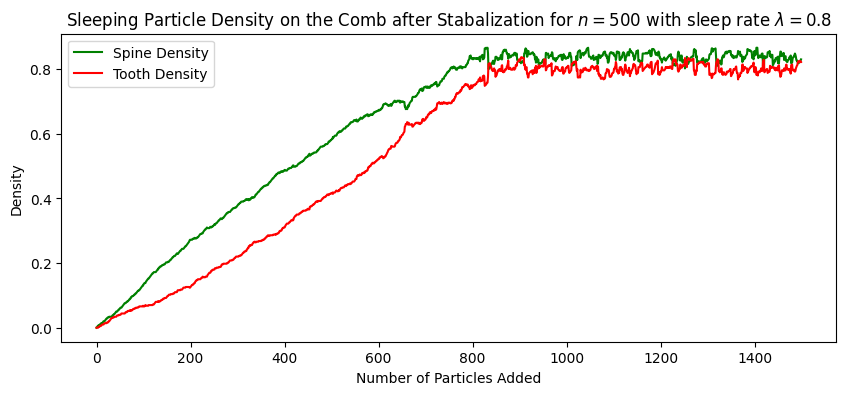

In [8]:
plt.figure(figsize=(10, 4))

plt.plot(np.arange(0, num_iters, 1), comb_data_full[1], color='g', label='Spine Density')
plt.plot(np.arange(0, num_iters, 1), comb_data_full[0], color='r', label='Tooth Density')

plt.xlabel("Number of Particles Added")
plt.ylabel("Density")
plt.title("Sleeping Particle Density on the Comb after Stabalization for $n=500$ with sleep rate $\lambda=0.8$")

plt.legend()
plt.savefig('CombHockeyStick.png', bbox_inches='tight', dpi=300)
plt.show()

plt.close()